In [1]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper')
from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *

import re 
import tqdm
import pickle
import collections
import itertools
import tables
import fbpca

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
import CEMBA_clst_utils
import enhancer_gene_utils 
importlib.reload(enhancer_gene_utils)
import plot_utils
importlib.reload(plot_utils)


<module 'plot_utils' from '/cndd/fangming/CEMBA/snmcseq_dev/plot_utils.py'>

In [2]:
import datetime
today = datetime.date.today() #.strftime("%y%m%d")

logger = snmcseq_utils.create_logger()

print(today)

2021-04-22


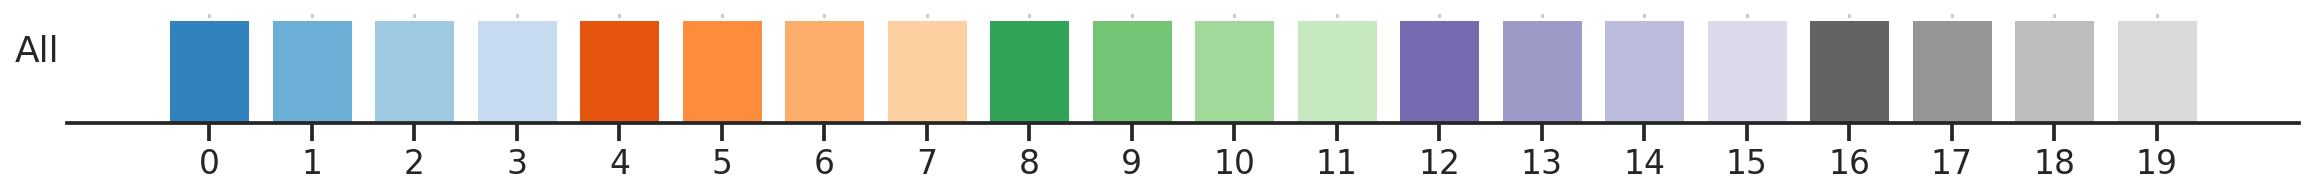

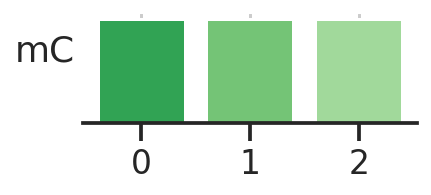

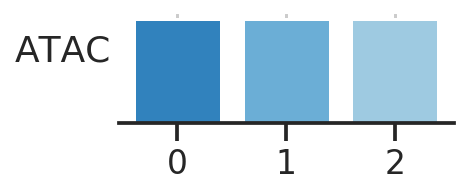

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


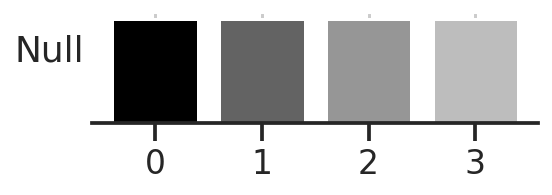

In [3]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

## Get gene by metacell tables 
- RNA
- mCG
- ATAC

In [4]:

CLUSTER_COL = 'cluster_r'

def pipe_corr_analysis_atac(
        common_modx_cells, common_mody_cells,
        cell_cell_knn_xaxis, cell_cell_knn_yaxis,
        common_genes, common_enhancer_regions,
        X, Y, 
        modx_clsts, knn_xy, 
        enhancer_gene_to_eval,
        output_corrs,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # new cells  
    common_modx_cells_updated = np.intersect1d(common_modx_cells, cell_cell_knn_xaxis)
    common_mody_cells_updated = np.intersect1d(common_mody_cells, cell_cell_knn_yaxis)

    # make sure the original matrices have the correct index
    x_idx = snmcseq_utils.get_index_from_array(common_modx_cells, common_modx_cells_updated)
    y_idx = snmcseq_utils.get_index_from_array(common_mody_cells, common_mody_cells_updated)
    X = X.tocsc()[:, x_idx] 
    Y = Y.tocsc()[:, y_idx]

    # make sure knn_xy, knn_xx have the right cell index
    cell_idx_xaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_xaxis, common_modx_cells_updated)
    cell_idx_yaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_yaxis, common_mody_cells_updated)
    knn_xy = knn_xy.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_yaxis] # x-by-y
    modx_clsts = modx_clsts.reindex(common_modx_cells_updated)

    logging.info("{}_{}_{}_{}".format(knn_xy.shape, modx_clsts.shape, X.shape, Y.shape,))

    for clst_col in modx_clsts.columns: 
        logging.info(clst_col)
        if clst_col.startswith(CLUSTER_COL):
    #         output_corr = output_corrs.format(clst_col)
    #         if not force and os.path.isfile(output_corr):
    #             logging.info("skip {}, already exists...".format(output_corr))
    #             continue # skip the existing file

            # choose one clustering to proceed
            uniq_labels = np.sort(modx_clsts[clst_col].unique()) 
            logging.info("Number of metacells: {}".format(len(uniq_labels)))
            if num_metacell_limit > 0 and len(uniq_labels) > num_metacell_limit:
                logging.info("skip {}, exceeding max num_metacell_limit...".format(len(uniq_labels)))
                continue
            knn_xz = enhancer_gene_utils.turn_cluster_labels_to_knn(modx_clsts[clst_col].values, 
                                                uniq_labels,
                                               )

            # Dec 21,2020
            # gene by metacell (counts)
            gc_rna = X.dot(knn_xz).todense() 
            # normalization (logCPM)
            gc_rna = snmcseq_utils.logcpm(pd.DataFrame(gc_rna)).values

            # Dec 21,2020
            enh_lengths = pd.Series((common_enhancer_regions['end']-common_enhancer_regions['start']).values)
            # enhancer by metacell (counts)
            knn_yz = knn_xy.T.dot(knn_xz)
            ec_atac = Y.dot(knn_yz).todense() 
            # normalization (logTPM)
            ec_atac = snmcseq_utils.logtpm(pd.DataFrame(ec_atac), enh_lengths).values
            logging.info("{} {}".format(gc_rna.shape, ec_atac.shape,))

    #         # corr analysis
    #         output_corr = output_corrs.format(clst_col)
    #         (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
    #             gc_rna, ec_atac, 
    #             common_genes, np.arange(len(ec_atac)),
    #             enhancer_gene_to_eval['gene'].values, 
    #             enhancer_gene_to_eval['ens'].values, 
    #             output_file=output_corr, corr_type=corr_type, chunksize=100000, verbose_level=0,
    #             )
            return (
                gc_rna, ec_atac, 
                common_genes, np.arange(len(ec_atac)),
                enhancer_gene_to_eval['gene'].values, 
                enhancer_gene_to_eval['ens'].values, 
                '', corr_type, 100000, 0,
            )

def wrap_corr_analysis_atac(
        mod_x, mod_y, 
        input_name_tag, i_sub,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # (i, k, --r)
    output_corrs = '/cndd2/fangming/projects/scf_enhancers/results/{}_{}_{{}}_{}_corrs.pkl'.format(input_name_tag, i_sub, corr_type)

    # input enh-gene tables, gene-by-cell, enhancer-by-cell matrices
    input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
    input_bundle_dirc = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9'
    bundle_fnames = (
        'cell_10x_cells_v3.txt',
        'cell_snatac_gene.txt',

        'gene_10x_cells_v3.txt',
        'enh.tsv',

        'mat_10x_cells_v3.npz',
        'mat_snatac_gene.npz',
    )


    # for knn_xx
    input_knn_dirc = '/cndd2/fangming/projects/miniatlas/results'
    input_modx_clsts = [
        'clusterings_{}_{}_sub{}.tsv.gz'.format(mod_x, input_name_tag, i_sub),
    ]

    # for knn_xy
    input_knn_xy = 'knn_across_{}_{}_{}.npz.{}.npz'.format(input_name_tag, mod_x, mod_y, i_sub) 
    input_knn_cells_xaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_x, input_name_tag, i_sub)
    input_knn_cells_yaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_y, input_name_tag, i_sub)

    # # Load data 
    # input_bundle
    with snmcseq_utils.cd(input_bundle_dirc):
        bundle = []
        for fname in bundle_fnames:
            #  save all as pickle file
            with open(fname, "rb") as fh:
                item = pickle.load(fh)
            bundle.append(item)
            logging.info("{}_{}_{}".format(type(item), item.shape, fname))

    (common_modx_cells, common_mody_cells, 
     common_genes, common_enhancer_regions,
     X, Y, 
    ) = bundle

    # input knn networks 
    with snmcseq_utils.cd(input_knn_dirc):
        # for knn_xx 
        # modx_clsts = pd.read_csv(input_modx_clsts, sep='\t',index_col=0)
        modx_clsts = pd.concat([
            pd.read_csv(fname, sep='\t',index_col=0)
            for fname in input_modx_clsts
        ], axis=1)
        # for knn_xy 
        knn_xy = sparse.load_npz(input_knn_xy)  
        cell_cell_knn_xaxis = np.load(input_knn_cells_xaxis, allow_pickle=True)
        cell_cell_knn_yaxis = np.load(input_knn_cells_yaxis, allow_pickle=True)

        logging.info("{} {} {} {}".format(modx_clsts.shape, knn_xy.shape, 
                                          cell_cell_knn_xaxis.shape, 
                                          cell_cell_knn_yaxis.shape,
                                         )
                    )

    # enhancer-gene linkage
    enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

    return pipe_corr_analysis_atac(
                common_modx_cells, common_mody_cells,
                cell_cell_knn_xaxis, cell_cell_knn_yaxis,
                common_genes, common_enhancer_regions,
                X, Y, 
                modx_clsts, knn_xy, 
                enhancer_gene_to_eval,
                output_corrs,
                corr_type=corr_type,
                force=force,
                num_metacell_limit=num_metacell_limit,
            )

def pipe_corr_analysis_mc(
        common_rna_cells, common_mc_cells,
        cell_cell_knn_xaxis, cell_cell_knn_yaxis,
        common_genes,
        X, Y_cg, Y_mcg, 
        modx_clsts, knn_xy, 
        enhancer_gene_to_eval,
        output_corrs,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # new cells  
    common_rna_cells_updated = np.intersect1d(common_rna_cells, cell_cell_knn_xaxis)
    common_mc_cells_updated = np.intersect1d(common_mc_cells, cell_cell_knn_yaxis)

    # make sure the original matrices have the correct index
    x_idx = snmcseq_utils.get_index_from_array(common_rna_cells, common_rna_cells_updated)
    y_idx = snmcseq_utils.get_index_from_array(common_mc_cells, common_mc_cells_updated)
    X = X.tocsc()[:, x_idx] 
    Y_cg = Y_cg.tocsc()[:, y_idx]
    Y_mcg = Y_mcg.tocsc()[:, y_idx] 

    # make sure knn_xy, knn_xx have the right cell index
    cell_idx_xaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_xaxis, common_rna_cells_updated)
    cell_idx_yaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_yaxis, common_mc_cells_updated)
    knn_xy = knn_xy.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_yaxis] # x-by-y
    modx_clsts = modx_clsts.reindex(common_rna_cells_updated)

    logging.info("{}_{}_{}_{}_{}".format(knn_xy.shape, modx_clsts.shape, X.shape, Y_cg.shape, Y_mcg.shape))

    for clst_col in modx_clsts.columns: 
        if clst_col.startswith(CLUSTER_COL):
            
            logging.info(clst_col)
        
#         output_corr = output_corrs.format(clst_col)
#         if not force and os.path.isfile(output_corr):
#             logging.info("skip {}, already exists...".format(output_corr))
#             continue # skip the existing file

            # choose one clustering to proceed
            uniq_labels = np.sort(modx_clsts[clst_col].unique()) 
            logging.info("Number of metacells: {}".format(len(uniq_labels)))
            if num_metacell_limit > 0 and len(uniq_labels) > num_metacell_limit:
                logging.info("skip {}, exceeding max num_metacell_limit...".format(len(uniq_labels)))

            knn_xz = enhancer_gene_utils.turn_cluster_labels_to_knn(modx_clsts[clst_col].values, 
                                                uniq_labels,
                                               )

            # # normalization - such that metacells made of more cells still sums to 1
            # knn_xz = knn_xz.dot(sparse.diags(np.ravel(1.0/knn_xz.sum(axis=0))))
            # # gene by metacell
            # gc_rna = X.dot(knn_xz).todense() 

            # gene by metacell (counts)
            gc_rna = X.dot(knn_xz).todense() 
            # normalization (logCPM)
            gc_rna = snmcseq_utils.logcpm(pd.DataFrame(gc_rna)).values

            # enhancer by metacell (counts cg, mcg)
            knn_yz = knn_xy.T.dot(knn_xz)
            ec_cg = Y_cg.dot(knn_yz).todense() 
            ec_mcg = Y_mcg.dot(knn_yz).todense()  
            logging.info("{} {} {}".format(gc_rna.shape, ec_cg.shape, ec_mcg.shape))

            # mC
            ec_mccg = snmcseq_utils.get_mcc_lite_v4(
                                           pd.DataFrame(ec_cg).astype(np.float32), 
                                           pd.DataFrame(ec_mcg).astype(np.float32), 
                                           base_call_cutoff=5, sufficient_coverage_fraction=0.8, fillna=True)
            logging.info("{}".format(ec_mccg.shape))

#             # corr analysis
#             (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
#                 gc_rna, ec_mccg, 
#                 common_genes, ec_mccg.index.values,
#                 enhancer_gene_to_eval['gene'].values, 
#                 enhancer_gene_to_eval['ens'].values, 
#                 output_file=output_corr, corr_type=corr_type, chunksize=100000, verbose_level=0,
#                 )
            return (
                gc_rna, ec_mccg, 
                common_genes, ec_mccg.index.values,
                enhancer_gene_to_eval['gene'].values, 
                enhancer_gene_to_eval['ens'].values, 
                '', corr_type, 100000, 0,
                )

def wrap_corr_analysis_mc(
        mod_x, mod_y, 
        input_nme_tag, i_sub,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # (i, k, --r)
    output_corrs = '/cndd2/fangming/projects/scf_enhancers/results/{}_{}_{{}}_{}_corrs.pkl'.format(input_name_tag, i_sub, corr_type)

    # input enh-gene tables, gene-by-cell, enhancer-by-cell matrices
    input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
    input_bundle_dirc = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9'
    bundle_fnames = (
        'cell_10x_cells_v3.txt',
        'cell_snmcseq_gene.txt',

        'gene_10x_cells_v3.txt',
        'enh.tsv',

        'mat_10x_cells_v3.npz',
        'mat_mcg_snmcseq_gene.npz',
        'mat_cg_snmcseq_gene.npz',
    )

    # for knn_xx
    input_knn_dirc = '/cndd2/fangming/projects/miniatlas/results'
    input_modx_clsts = [
        'clusterings_{}_{}_sub{}.tsv.gz'.format(mod_x, input_name_tag, i_sub),
    ]

    # for knn_xy
    input_knn_xy = 'knn_across_{}_{}_{}.npz.{}.npz'.format(input_name_tag, mod_x, mod_y, i_sub) 
    input_knn_cells_xaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_x, input_name_tag, i_sub)
    input_knn_cells_yaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_y, input_name_tag, i_sub)

    # # Load data 
    # input_bundle
    with snmcseq_utils.cd(input_bundle_dirc):
        bundle = []
        for fname in bundle_fnames:
            #  save all as pickle file
            with open(fname, "rb") as fh:
                item = pickle.load(fh)
            bundle.append(item)
            logging.info("{}_{}_{}".format(type(item), item.shape, fname))

    (common_rna_cells, common_mc_cells, 
     common_genes, common_enhancer_regions,
     X, Y_mcg, Y_cg, 
    #  knn_xy, knn_xx,
    ) = bundle

    # input knn networks 
    with snmcseq_utils.cd(input_knn_dirc):
        # for knn_xx 
        # modx_clsts = pd.read_csv(input_modx_clsts, sep='\t',index_col=0)
        modx_clsts = pd.concat([
            pd.read_csv(fname, sep='\t',index_col=0)
            for fname in input_modx_clsts
        ], axis=1)
        # for knn_xy 
        knn_xy = sparse.load_npz(input_knn_xy)  
        cell_cell_knn_xaxis = np.load(input_knn_cells_xaxis, allow_pickle=True)
        cell_cell_knn_yaxis = np.load(input_knn_cells_yaxis, allow_pickle=True)

        logging.info("{} {} {} {}".format(
              modx_clsts.shape, 
              knn_xy.shape, 
              cell_cell_knn_xaxis.shape, 
              cell_cell_knn_yaxis.shape,
              )
             )

    # enhancer-gene linkage
    enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')
    return pipe_corr_analysis_mc(
                common_rna_cells, common_mc_cells,
                cell_cell_knn_xaxis, cell_cell_knn_yaxis,
                common_genes,
                X, Y_cg, Y_mcg, 
                modx_clsts, knn_xy, 
                enhancer_gene_to_eval,
                output_corrs,
                corr_type=corr_type,
                force=force,
                num_metacell_limit=num_metacell_limit,
            )

In [5]:
mod_x, mod_y = '10x_cells_v3', 'snatac_gene'
ka = 30 
knn = 30 
date = "201206"
input_name_tag = 'mop_{}_{}_ka{}_knn{}_{}'.format(mod_x, mod_y, ka, knn, date)
i_sub = '0'

CLUSTER_COL = 'cluster_r25'
res1 = wrap_corr_analysis_atac(
                            mod_x, mod_y, 
                            input_name_tag, i_sub,
                            corr_type='spearmanr',
                            force=False,
                            num_metacell_limit=0,
                    )
gc_rna1, ec_atac = res1[:2]
print(gc_rna1.shape, ec_atac.shape)

mod_x, mod_y = '10x_cells_v3', 'snmcseq_gene'
ka = 30 
knn = 30 
date = "201130"
input_name_tag = 'mop_{}_{}_ka{}_knn{}_{}'.format(mod_x, mod_y, ka, knn, date)
i_sub = '0'
res2 = wrap_corr_analysis_mc(
                            mod_x, mod_y, 
                            input_name_tag, i_sub,
    #                         corr_type='pearsonr',
                            force=False,
                            num_metacell_limit=0,
                    )
gc_rna2, ec_mccg = res2[:2]
print(gc_rna2.shape, ec_mccg.shape)

04/22/2021 07:47:14 PM <class 'numpy.ndarray'>_(69727,)_cell_10x_cells_v3.txt
04/22/2021 07:47:14 PM <class 'numpy.ndarray'>_(135665,)_cell_snatac_gene.txt
04/22/2021 07:47:14 PM <class 'numpy.ndarray'>_(31053,)_gene_10x_cells_v3.txt
04/22/2021 07:47:14 PM <class 'pandas.core.frame.DataFrame'>_(233514, 3)_enh.tsv
04/22/2021 07:47:16 PM <class 'scipy.sparse.csc.csc_matrix'>_(31053, 69727)_mat_10x_cells_v3.npz
04/22/2021 07:47:17 PM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 135665)_mat_snatac_gene.npz
04/22/2021 07:47:17 PM (69727, 41) (69727, 54844) (69727,) (54844,)
04/22/2021 07:47:28 PM (69727, 54844)_(69727, 41)_(31053, 69727)_(233514, 54844)
04/22/2021 07:47:28 PM cluster_r1.0
04/22/2021 07:47:28 PM cluster_r1.2589254117941673
04/22/2021 07:47:28 PM cluster_r1.5848931924611136
04/22/2021 07:47:28 PM cluster_r1.9952623149688797
04/22/2021 07:47:28 PM cluster_r2.51188643150958
04/22/2021 07:47:28 PM cluster_r3.1622776601683795
04/22/2021 07:47:28 PM cluster_r3.981071705534973
04

(31053, 256) (233514, 256)


04/22/2021 07:47:48 PM <class 'scipy.sparse.csc.csc_matrix'>_(31053, 69727)_mat_10x_cells_v3.npz
04/22/2021 07:47:50 PM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 9931)_mat_mcg_snmcseq_gene.npz
04/22/2021 07:47:52 PM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 9931)_mat_cg_snmcseq_gene.npz
04/22/2021 07:47:52 PM (55912, 41) (55912, 7499) (55912,) (7499,)
04/22/2021 07:48:01 PM (55912, 7497)_(55912, 41)_(31053, 55912)_(233514, 7497)_(233514, 7497)
04/22/2021 07:48:01 PM cluster_r25.11886431509581
04/22/2021 07:48:01 PM Number of metacells: 248
04/22/2021 07:48:48 PM (31053, 248) (233514, 248) (233514, 248)
04/22/2021 07:48:49 PM Imputing data... (No effect if sufficient_coverage_fraction=1)
04/22/2021 07:48:50 PM (233512, 248)


(31053, 248) (233512, 248)


In [6]:
# enhancer_gene_pairs
f = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
enh_gene_table = pd.read_csv(f, sep='\t')
print(enh_gene_table.shape)

(2589994, 18)


In [7]:
# 0 gc_rna
# 1 ec_mccg 
# 2 common_genes
# 3 ec_mccg.index.values
# 4 enhancer_gene_to_eval['gene'].values 
# 5 enhancer_gene_to_eval['ens'].values
# 6 ''
# 7 corr_type
# 8 100000
# 9 0

res2[4].shape, res2[5].shape

((2589994,), (2589994,))

## analysis

- shuffle enhancers and control for
- distance to nearest gene
- GC_content
- ...

In [8]:
def plot_routine(res_corrs1, res_corrs2, title1, title2, corr_type, ylim1=[], ylim2=[]):
    """
    """
    # output = output_figures.format('hist_corr_both.pdf')
    
    bins = np.linspace(-1, 1, 201)
    
    fig = plt.figure(figsize=(5*2, 5))
    gs = fig.add_gridspec(3, 2)
    axs = np.array([[fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),],
                    [fig.add_subplot(gs[1:, 0]), fig.add_subplot(gs[1:, 1]),],
                   ])
    for j, (res_corrs, title) in enumerate(zip([res_corrs1, res_corrs2], 
                                             [title1, title2],
                                        )):
        KB = 1000
        labels_base = [
                  'shuffled metacells',
                  'shuffled genes',
                  'shuffled enhs',
                  'shuffled enhs bygroups',
                  '<500kb',
                  '<100kb',
                 ] 
        # corr1
        labels = [label+' mCG-RNA' for label in labels_base]
        corr_tracks = [
               res_corrs['corr_shuff_cells'].values,
               res_corrs['corr_shuff'].values,
               res_corrs['corr_shuff_enhs'].values,
               res_corrs['corr_shuff_enhs_bygroups'].values,
               res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
               res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
              ]
        colors = [colors_null[1], 
                  colors_null[0], 
                  colors_null[2],
                  'r',
                  colors_mc[1], 
                  colors_mc[0],
                 ]
    
        ymax = 0
        ax_col = axs[:,j]
        for ax in ax_col:
            for i, track in enumerate(corr_tracks):
                _y, _x, _ = ax.hist(track, bins=bins, density=True, label=labels[i], histtype='step', color=colors[i])
                ymax = max(ymax, np.max(_y))
            _handles, _labels = ax.get_legend_handles_labels()
            _handles = [mpl.lines.Line2D([], [], c=h.get_edgecolor()) for h in _handles]
            
        ax1, ax2 = ax_col
        # ylims
        if not len(ylim1): ylim1 = [0.9*ymax, 1.1*ymax]
        if not len(ylim2): ylim2 = [0, 0.2*ymax] 
        # set slanted y axis
        plot_utils.set_broken_yaxis(ax1, ax2, ylim1, ylim2)
        # limit number of y ticks
        ax1.yaxis.set_major_locator(mtick.MaxNLocator(2))
        ax2.yaxis.set_major_locator(mtick.MaxNLocator(4))
        # labels
        ax1.set_title(title)
        ax2.set_xlabel('{} correlation'.format(corr_type))
        ax2.set_ylabel('Density')

        
    ax.legend(_handles, _labels, bbox_to_anchor=(1,1))
    plt.show()

In [9]:
import enhancer_gene_utils 
importlib.reload(enhancer_gene_utils)

<module 'enhancer_gene_utils' from '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper/enhancer_gene_utils.py'>

In [10]:
y_gc = gc_rna2 #- np.mean(gc_rna2, axis=0)
x_ec = ec_mccg
print(x_ec.shape, y_gc.shape)

(233512, 248) (31053, 248)


In [11]:
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhs_list_annotated.tsv' 
enh_annot = pd.read_csv(f, sep='\t', index_col=0)
print(enh_annot.shape)
enh_annot.head()

(233514, 16)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,chr,start,end,length,chrom,center,trpt_chr,trpt_start,trpt_end,strand,trpt_id,trpt_name,gene_id,gene_name,dist,GC_frac
index,,,,,,,,,,,,,,,,
0,chr1,3083769,3083816,47,1,3083792,chr1,3073253,3073254,+,ENSMUST00000193812.1,4933401J01Rik-201,ENSMUSG00000102693.1,4933401J01Rik,10516,0.553191
1,chr1,3112234,3112467,233,1,3112350,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10218,0.502146
2,chr1,3112770,3112986,216,1,3112878,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10754,0.351852
3,chr1,3113717,3114035,318,1,3113876,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,11701,0.377358
4,chr1,3118790,3118935,145,1,3118862,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,16774,0.496552


In [12]:
enh_annot.reindex(res2[5])['GC_frac']
enh_annot.reindex(res2[5])['dist']

index
147520    31866
147522    22275
147523    20481
147527     7249
147528     6029
          ...  
70259      2070
70260      9294
70264      4584
70265     21812
70271      4996
Name: dist, Length: 2589994, dtype: int64

In [13]:
def interval_array_to_break_points(array):
    newarray = []
    for item in array:
        newarray.append(item.left)
    newarray.append(item.right)
    return newarray


/cndd2/fangming/projects/scf_enhancers/results_jan2021/enh_gccontent_hist.pdf


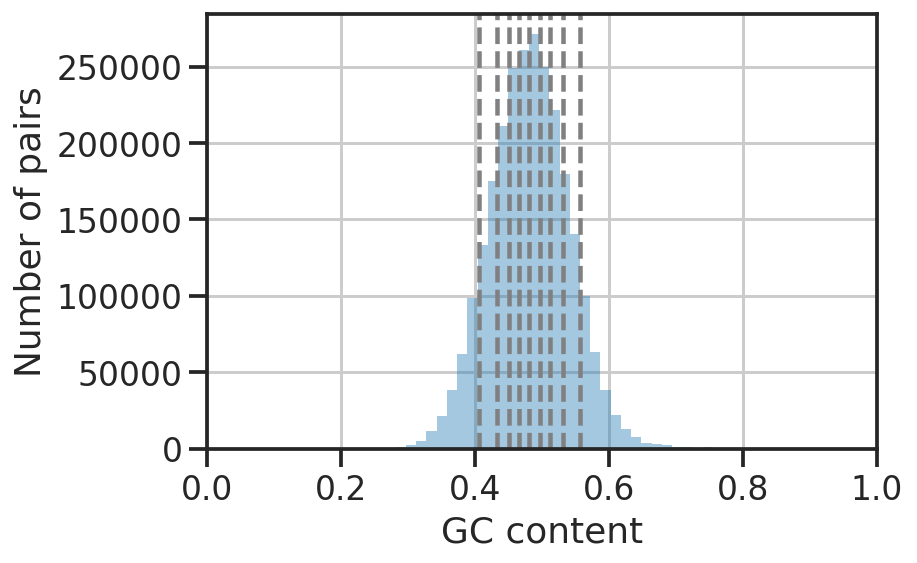

/cndd2/fangming/projects/scf_enhancers/results_jan2021/enh_distnngene_hist.pdf


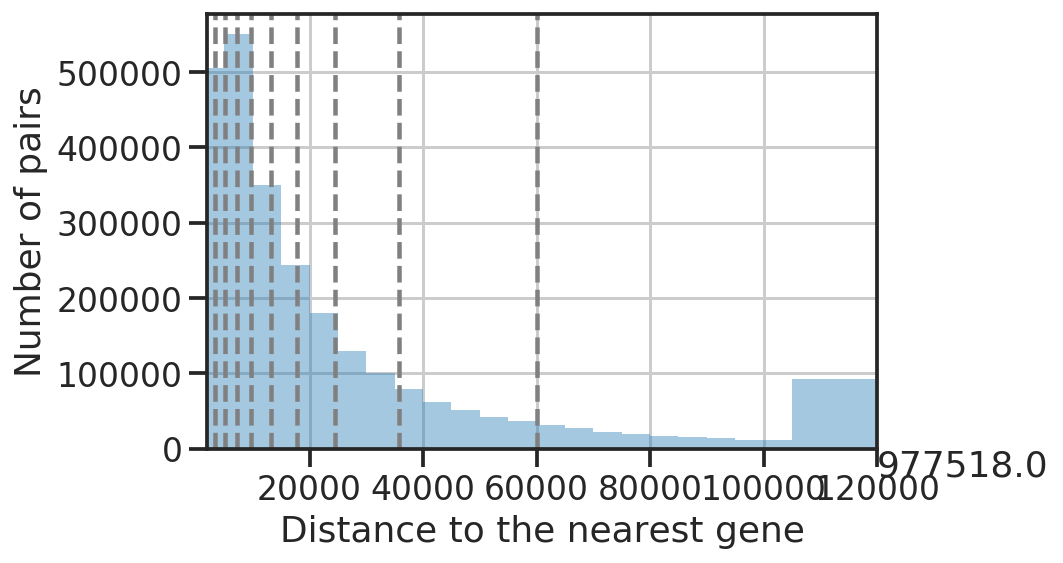

In [14]:
# run_results
# regression (applied to each gene and enh pair) -- correlate gene-enh
rdate = 'Mar2'

KB = 1000

# gc content interval 
num_bins = 10
enh_gc_fracs = enh_annot.reindex(res2[5])['GC_frac']
# enh_gc_bins = np.arange(0, 1.1, 0.1)
# enh_gc_groups = pd.cut(enh_gc_fracs, 
#                        bins=enh_gc_bins,)
enh_gc_groups = pd.qcut(enh_gc_fracs, num_bins)
enh_gc_bins = interval_array_to_break_points(enh_gc_groups.cat.categories.values)
enh_gc_groups = enh_gc_groups[~enh_gc_groups.index.duplicated(keep='first')].reindex(res2[3])

# dist groups 10kb interval to 100kb; >100kb
enh_dists = enh_annot.reindex(res2[5])['dist']
# enh_dists_bins = np.hstack([np.arange(0, 110*KB, 10*KB), [enh_dists.max()]])
# enh_dist_groups = pd.cut(enh_dists, 
#                          bins=enh_dists_bins,)
enh_dist_groups = pd.qcut(enh_dists, num_bins)
enh_dist_bins = interval_array_to_break_points(enh_dist_groups.cat.categories.values)
enh_dist_groups = enh_dist_groups[~enh_dist_groups.index.duplicated(keep='first')].reindex(res2[3])

# 
output = "/cndd2/fangming/projects/scf_enhancers/results_jan2021/enh_gccontent_hist.pdf"
fig, ax = plt.subplots()
sns.distplot(enh_gc_fracs, 
             kde=False,
             hist_kws=dict(edgecolor='none'),
             ax=ax)
# decile
for i in enh_gc_bins[1:-1]:
    ax.axvline(i, color='gray', linestyle='--')
ax.set_xlabel('GC content')
ax.set_ylabel('Number of pairs')
ax.set_xlim(xmin=0, xmax=1)
print(output)
snmcseq_utils.savefig(fig, output)
plt.show()

# 
output = "/cndd2/fangming/projects/scf_enhancers/results_jan2021/enh_distnngene_hist.pdf"
fig, ax = plt.subplots()
sns.distplot(enh_dists, 
             bins=np.hstack([np.arange(0, 110*KB, 5*KB), [enh_dists.max()]]), 
             kde=False,
             hist_kws=dict(edgecolor='none'),
             ax=ax)
# decile
for i in enh_dist_bins[1:-1]:
    ax.axvline(i, color='gray', linestyle='--')
ax.set_xlim(xmin=2*KB, xmax=120*KB)

ax.text(1, 0, enh_dist_bins[-1], transform=ax.transAxes, va='top')
ax.set_xlabel('Distance to the nearest gene')
ax.set_ylabel('Number of pairs')
print(output)
snmcseq_utils.savefig(fig, output)
plt.show()


In [15]:
# run_results
# regression (applied to each gene and enh pair) -- correlate gene-enh
rdate = 'April22'

# # gc content interval 
# num_bins = 10
# enh_gc_fracs = enh_annot.reindex(res2[3])['GC_frac']
# enh_gc_groups = pd.cut(enh_gc_fracs, 
#                        bins=np.arange(0, 1.1, 0.1))

# # dist groups 10kb interval to 100kb; >100kb
# # enh_dist_groups = pd.cut(enh_annot.reindex(res2[3])['dist'], num_bins)
# KB = 1000
# enh_dists = enh_annot.reindex(res2[3])['dist']
# enh_dist_groups = pd.cut(enh_dists, 
#                          bins=np.hstack([np.arange(0, 110*KB, 10*KB), [enh_dists.max()]])
#                         )

configs = [
    (y_gc, x_ec, enh_gc_groups.values, 
     'spearmanr', 'test_ctrl_gc_mcrna_spearmanr_{}.pkl'.format(rdate)),
    
    (y_gc, x_ec, enh_dist_groups.values,  
     'spearmanr', 'test_ctrl_dist_mcrna_spearmanr_{}.pkl'.format(rdate)),
]

for config in configs:
    y, x, enhancer_groups, corr_type, output_fname = config
    # # corr analysis
    output_file = ('/cndd2/fangming/projects/scf_enhancers/results_jan2021/{}'.format(output_fname))
    print(output_file)
    
    print('enhancer groups', len(enhancer_groups))
    output = enhancer_gene_utils.compute_enh_gene_corrs(
        y, x,
        res2[2], res2[3],
        res2[4], res2[5],
        enhancer_groups=enhancer_groups,
        output_file=output_file, corr_type=corr_type,
        shuff_enhs=True,
    )

/cndd2/fangming/projects/scf_enhancers/results_jan2021/test_ctrl_gc_mcrna_spearmanr_April22.pkl
enhancer groups 233512
spearmanr chosen!


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


0 0.0019459724426269531
100000 0.15723395347595215
200000 0.3116931915283203
300000 0.46121764183044434
400000 0.6086869239807129
500000 0.7557072639465332
600000 0.903242826461792
700000 1.0508029460906982
800000 1.2022693157196045
900000 1.3504011631011963
1000000 1.498725414276123
1100000 1.6462619304656982
1200000 1.7986645698547363
1300000 1.9528517723083496
1400000 2.1054630279541016
1500000 2.257905960083008
1600000 2.4138221740722656
1700000 2.5777382850646973
1800000 2.738438606262207
1900000 2.899348020553589
2000000 3.057919979095459
2100000 3.2156662940979004
2200000 3.3745336532592773
2300000 3.5329108238220215
0 0.0019638538360595703
100000 0.16095995903015137
200000 0.3190186023712158
300000 0.48003530502319336
400000 0.6321275234222412
500000 0.7835125923156738
600000 0.9362404346466064
700000 1.0874366760253906
800000 1.2365570068359375
900000 1.3857643604278564
1000000 1.5368258953094482
1100000 1.6879403591156006
1200000 1.8465073108673096
1300000 2.0030570030212402


In [16]:
# retreve results
# regression (applied to each gene and enh pair) -- correlate gene-enh

# rdate = 'Mar2'
configs = [
    ('spearman_mcrna_ctrl_gc', y_gc, x_ec, enh_gc_groups, 
     'spearmanr', 'test_ctrl_gc_mcrna_spearmanr_{}.pkl'.format(rdate)),
    
    ('spearman_mcrna_ctrl_dist', y_gc, x_ec, enh_dist_groups, 
     'spearmanr', 'test_ctrl_dist_mcrna_spearmanr_{}.pkl'.format(rdate)),
]

res_corrs_all = {}
for config in configs:
    label, y, x, enh_groups, corr_type, output_fname = config
    # # corr analysis
    output_file = ('/cndd2/fangming/projects/scf_enhancers/results_jan2021/{}'.format(output_fname))
    print(output_file)
    with open(output_file, 'rb') as fh:
        (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells, 
         corrs_shuffled_enhs,
         corrs_shuffled_enhs_bygroups,
        ) = pickle.load(fh)
    
    to_evals = enh_gene_table
    res_corrs = to_evals[to_correlate].copy()
    res_corrs['enh_group'] = enh_groups.reindex(res_corrs['ens']).values 
    res_corrs['corr'] = corrs 
    res_corrs['corr_shuff'] = corrs_shuffled
    res_corrs['corr_shuff_cells'] = corrs_shuffled_cells
    res_corrs['corr_shuff_enhs'] = corrs_shuffled_enhs
    res_corrs['corr_shuff_enhs_bygroups'] = corrs_shuffled_enhs_bygroups
    
    res_corrs_all[label] = res_corrs

/cndd2/fangming/projects/scf_enhancers/results_jan2021/test_ctrl_gc_mcrna_spearmanr_April22.pkl
/cndd2/fangming/projects/scf_enhancers/results_jan2021/test_ctrl_dist_mcrna_spearmanr_April22.pkl


In [17]:
# res_corrs[['GC_frac', 'dist']] = enh_annot.loc[res_corrs['ens'])[['GC_frac', 'dist']]
res_corrs.head()

,gene,ens,val,val2,val_clustershuffled,val2_clustershuffled,dist,pvalues,fdr<100kb,fdr<200kb,...,fdr2<200kb,fdr2<500kb,fdr2<100kb shuffled (cluster label),val_both,enh_group,corr,corr_shuff,corr_shuff_cells,corr_shuff_enhs,corr_shuff_enhs_bygroups
0,ENSMUSG00000000001,147520,-0.157895,0.127913,-0.169712,-0.049349,995118,0.288079,0.674683,0.736811,...,0.797076,0.872822,1.955898,-0.285808,"(24477.0, 35727.0]",0.032832,0.026095,0.041572,0.026506,0.102303
1,ENSMUSG00000000001,147522,0.027465,-0.307145,0.064887,0.105591,985740,0.561881,0.830849,0.867082,...,0.979844,0.987476,0.959470,0.334610,"(17859.0, 24477.0]",0.110235,-0.261110,-0.165309,0.159408,-0.117846
2,ENSMUSG00000000001,147523,-0.040376,0.011489,-0.155487,0.014772,983725,0.457686,0.780196,0.825259,...,0.874844,0.922832,1.273339,-0.051866,"(17859.0, 24477.0]",0.005287,-0.202394,-0.165038,0.186046,0.029836
3,ENSMUSG00000000001,147527,-0.070795,0.111719,-0.088084,0.184594,970444,0.411564,0.755088,0.804341,...,0.809464,0.880982,1.812516,-0.182514,"(7156.0, 9764.0]",-0.163406,-0.272649,-0.024878,0.132119,0.091685
4,ENSMUSG00000000001,147528,0.012583,0.150673,-0.036218,0.147609,969372,0.539123,0.819981,0.858026,...,0.780447,0.862033,2.191506,-0.138090,"(5087.0, 7156.0]",-0.173182,-0.197901,-0.127460,0.111731,-0.130875


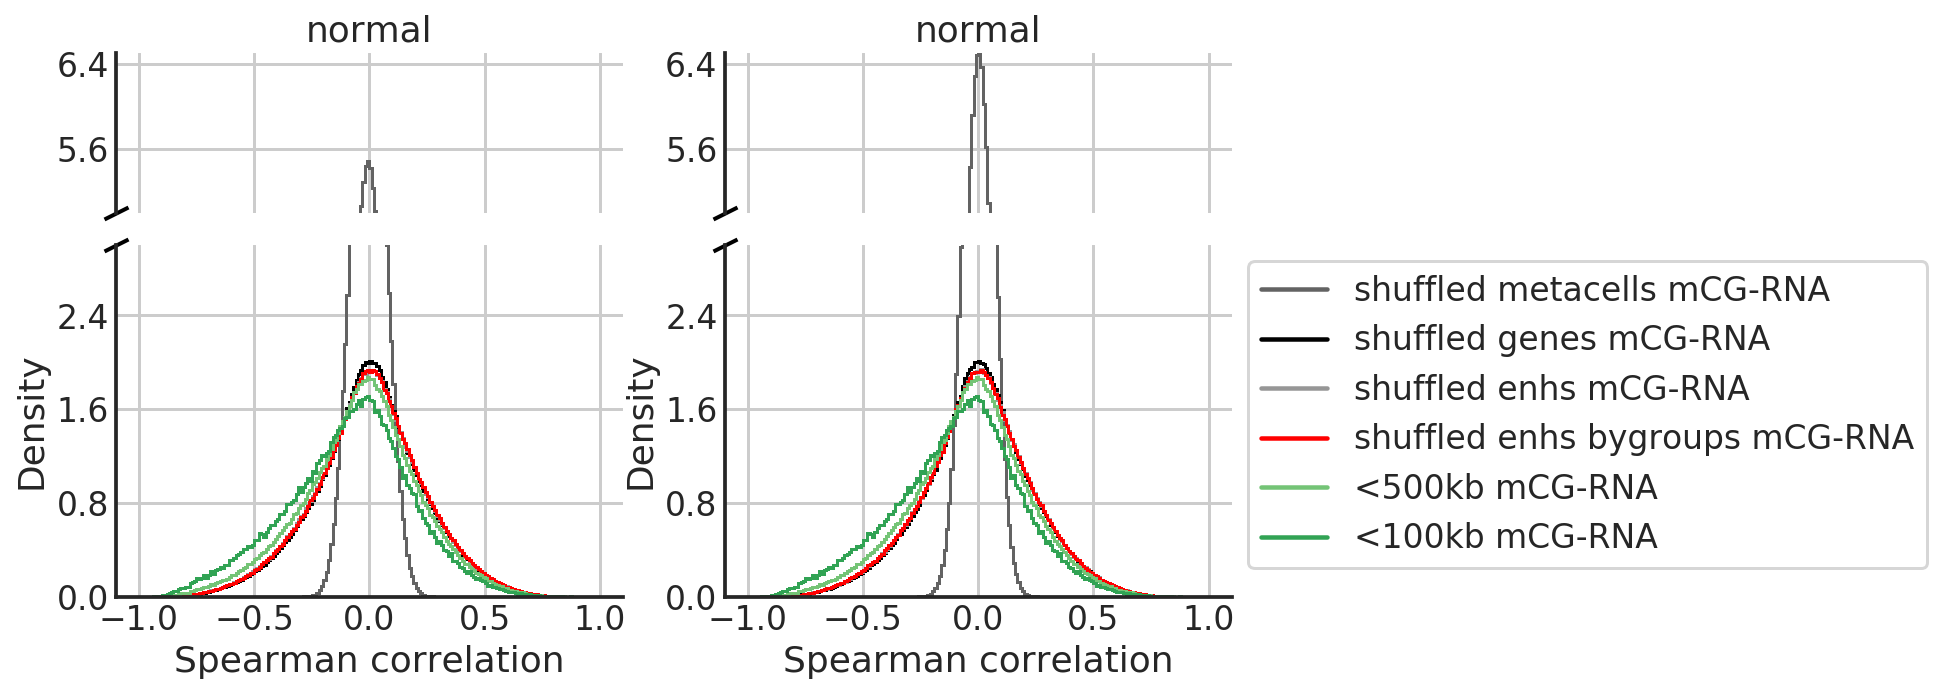

In [18]:
plot_routine(res_corrs_all['spearman_mcrna_ctrl_gc'], 
             res_corrs_all['spearman_mcrna_ctrl_dist'], 
             'normal', 'normal', 'Spearman', 
             ylim1=[5, 6.5], ylim2=[0, 3],
            )

# display different groups 

In [19]:
def simple_plot_routine(res_corrs, title, corr_type, ylim1=[], ylim2=[], bins=np.linspace(-1, 1, 201)):
    """
    """
    # output = output_figures.format('hist_corr_both.pdf')
    
    fig = plt.figure(figsize=(5*1, 5))
    gs = fig.add_gridspec(3, 1)
    axs = np.array([fig.add_subplot(gs[0, 0]), 
                    fig.add_subplot(gs[1:, 0]), 
                   ])
    
    KB = 1000
    
    corr_tracks = [
#            res_corrs['corr_shuff_cells'].values,
           res_corrs['corr_shuff'].values,
           res_corrs['corr_shuff_enhs'].values,
           res_corrs['corr_shuff_enhs_bygroups'].values,
           res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
           res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
          ]
    
    labels = [
#               'shuffled metacells',
              'shuffled genes',
              'shuffled enhs',
              'shuffled enhs bygroups',
              '<500kb',
              '<100kb',
             ] 
    colors = [
#               colors_null[1], 
              colors_null[0], 
              colors_null[2],
              'r',
              colors_mc[1], 
              colors_mc[0],
              
              'C0', 'C1', 'C3'
             ]

    for grp, df_grp in res_corrs.groupby('enh_group'):
#         track = df_grp.loc[df_grp['dist']<=100*KB, 'corr'].values
        track = df_grp['corr_shuff_enhs_bygroups'].values
        corr_tracks.append(track)
        labels.append(grp)
        
    ymax = 0
    for ax in axs:
        for i, track in enumerate(corr_tracks):
            _y, _x, _ = ax.hist(track, bins=bins, density=True, label=labels[i], histtype='step', color=colors[i])
            ymax = max(ymax, np.max(_y))
        _handles, _labels = ax.get_legend_handles_labels()
        _handles = [mpl.lines.Line2D([], [], c=h.get_edgecolor()) for h in _handles]

    ax1, ax2 = axs
    # ylims
    if not len(ylim1): ylim1 = [0.9*ymax, 1.1*ymax]
    if not len(ylim2): ylim2 = [0, 0.2*ymax] 
    # set slanted y axis
    plot_utils.set_broken_yaxis(ax1, ax2, ylim1, ylim2)
    # limit number of y ticks
    ax1.yaxis.set_major_locator(mtick.MaxNLocator(2))
    ax2.yaxis.set_major_locator(mtick.MaxNLocator(4))
    # labels
    ax1.set_title(title)
    ax2.set_xlabel('{} correlation'.format(corr_type))
    ax2.set_ylabel('Density')
        
    ax.legend(_handles, _labels, bbox_to_anchor=(1,1))
    plt.show()

In [20]:
def setup_cdf_tracks(res_corrs, overall_label, num_bins, bins=np.linspace(-1, 1, 201)):
    KB = 1000
    
    # set up track configs and tracks
    track_configs = [
    ]
    # enhs
    grad_colors = snmcseq_utils.get_grad_colors(num_bins+3, cmap='Greens_r')[1:]
    for j, (grp, df_grp) in enumerate(res_corrs.groupby('enh_group')):
        track = df_grp.loc[df_grp['dist']<=100*KB, 'corr'].values
        label = "<100kb {} {}".format(overall_label, grp)
        color = grad_colors[j]
        
        _y, _x = np.histogram(track, bins=bins,)
        _x = _x[1:]
        _y = np.cumsum(_y)/np.sum(_y)
        
        track_configs.append(
            (label, track, color, _x, _y)
        )
    # shuffled enhs
    grad_colors = snmcseq_utils.get_grad_colors(num_bins+3, cmap='Reds_r')[1:]
    for j, (grp, df_grp) in enumerate(res_corrs.groupby('enh_group')):
        track = df_grp['corr_shuff_enhs_bygroups'].values
        label = "shuffled enhs {} {}".format(overall_label, grp)
        color = grad_colors[j]
        
        _y, _x = np.histogram(track, bins=bins,)
        _x = _x[1:]
        _y = np.cumsum(_y)/np.sum(_y)
        
        track_configs.append(
            (label, track, color, _x, _y)
        )
    return track_configs

def simple_plot_routine_cdf_v2(track_configs, num_bins, title, corr_type, ylim1=[], ylim2=[], output=''):
    """
    """
    # set up the figures 
    fig = plt.figure(figsize=((num_bins+2)*3, 2*3))
    gs = fig.add_gridspec(2, num_bins+2)
    axs = np.hstack([
        [fig.add_subplot(gs[0:2, 0:2]),],
        [fig.add_subplot(gs[0, 2+i]) for i in np.arange(num_bins)],
        [fig.add_subplot(gs[1, 2+i]) for i in np.arange(num_bins)],
    ])
    
    # one plot
    ax = axs[0]
    for i, config in enumerate(track_configs):
        label, track, color, _x, _y = config
        ax.plot(_x, _y, label=label, color=color, linewidth=3, alpha=1)
        _handles, _labels = ax.get_legend_handles_labels()
    # labels
    ax.set_xlabel('{} correlation'.format(corr_type))
    ax.set_ylabel('Cumulative fraction of pairs')
    ax.legend(_handles, _labels, bbox_to_anchor=(0,-0.2), loc='upper left', ncol=2)
    ax.set_title(title)
    
    # many plots
    for j, ax in enumerate(axs[1:]):
        # all tracks first
        for i, config in enumerate(track_configs):
            label, track, color, _x, _y = config
            color='lightgray'
            ax.plot(_x, _y, label=label, color=color, linewidth=1, alpha=1)
            
        # this track
        label, track, color, _x, _y = track_configs[j]
        ax.plot(_x, _y, label=label, color=color, linewidth=3, alpha=1)
        ax.set_xticks([-1, 1])
        ax.set_yticks([0, 1])
        
        if j < num_bins:
            short_label = "("+label.split('(')[1]
            ax.set_title(short_label)
    
    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    if output:
        snmcseq_utils.savefig(fig, output)
    plt.show()

In [21]:
track_configs_gc = setup_cdf_tracks(res_corrs_all['spearman_mcrna_ctrl_gc'], "GC content", num_bins, bins=np.linspace(-1, 1, 51))
track_configs_dist = setup_cdf_tracks(res_corrs_all['spearman_mcrna_ctrl_dist'], "distance to nearest gene", num_bins, bins=np.linspace(-1, 1, 51))

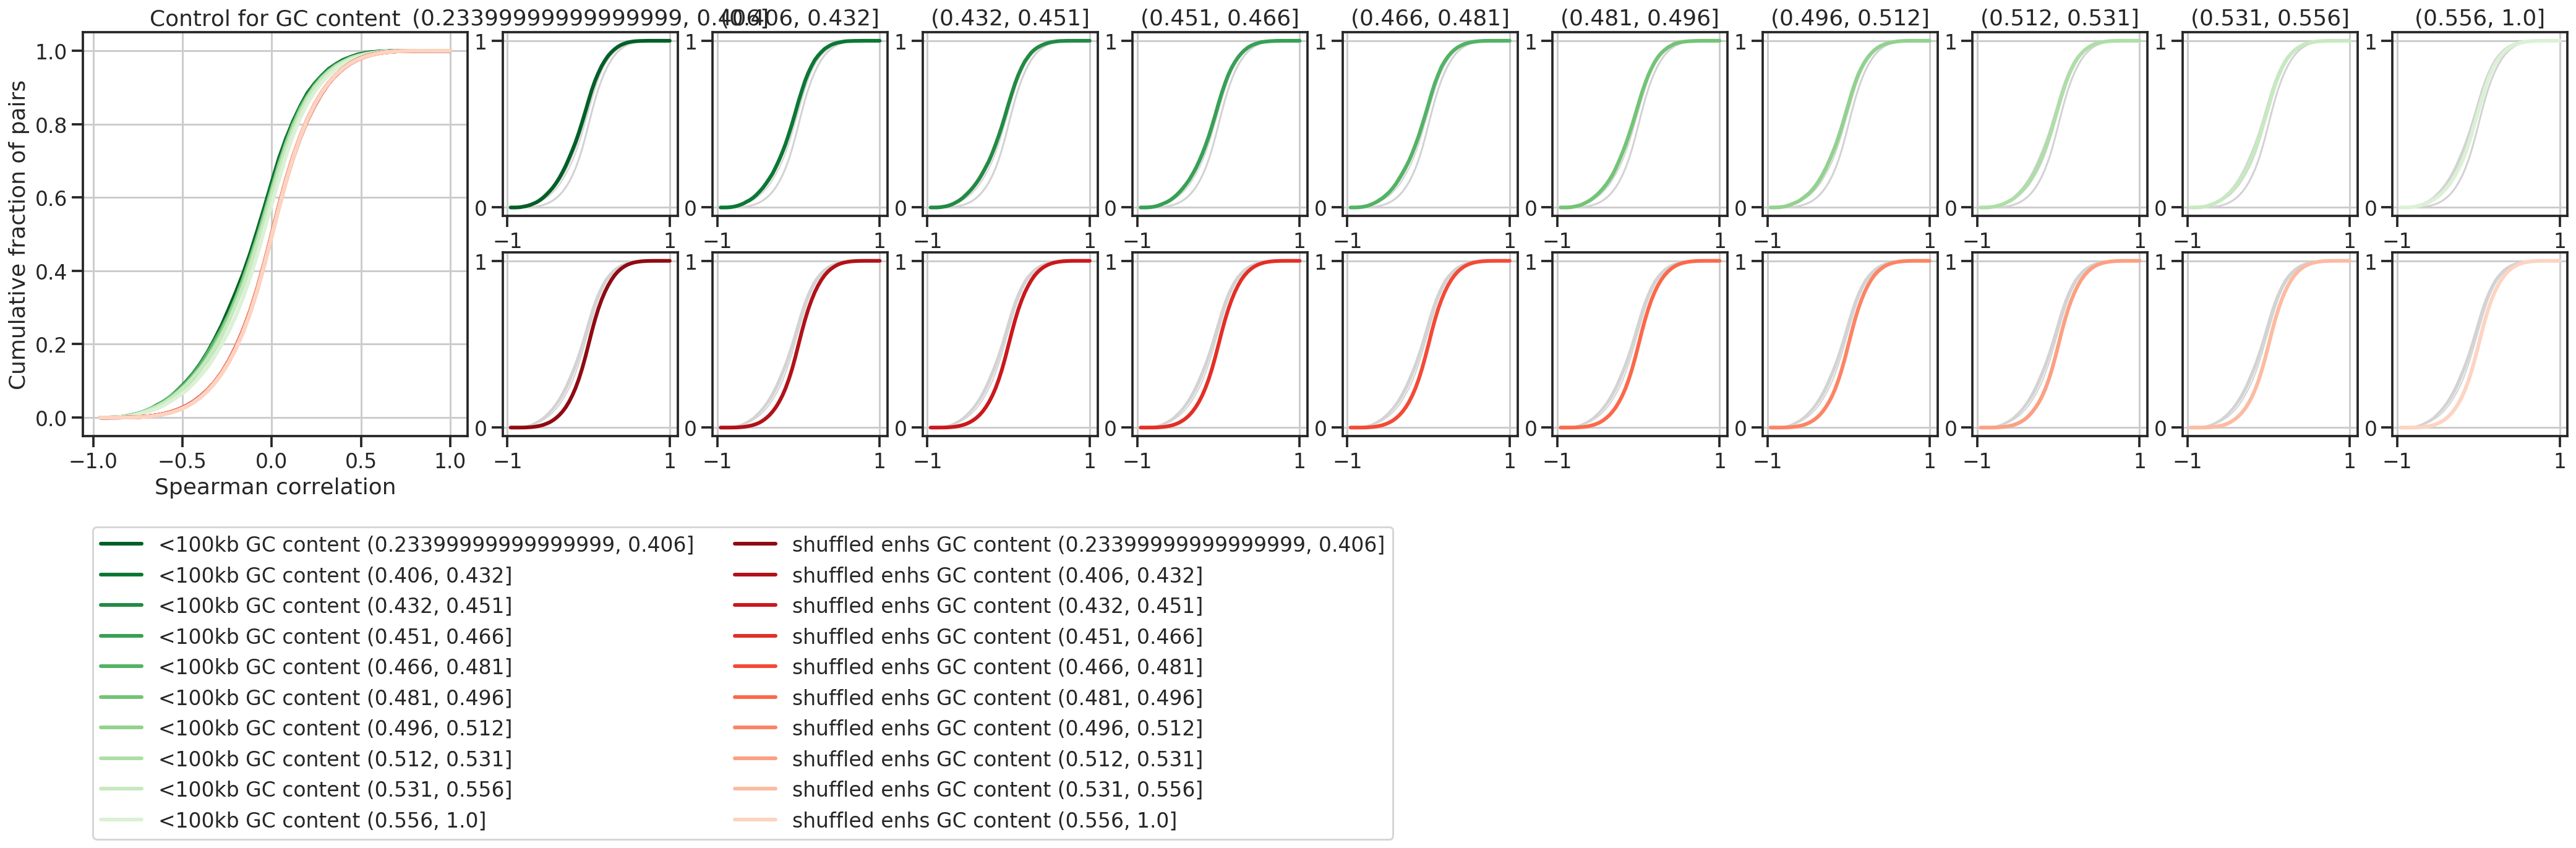

In [22]:
simple_plot_routine_cdf_v2(track_configs_gc, num_bins, 'Control for GC content', 'Spearman', ylim1=[], ylim2=[], 
                           output='/cndd2/fangming/projects/scf_enhancers/results_jan2021/cdf_control_gc_content.pdf'
                          )

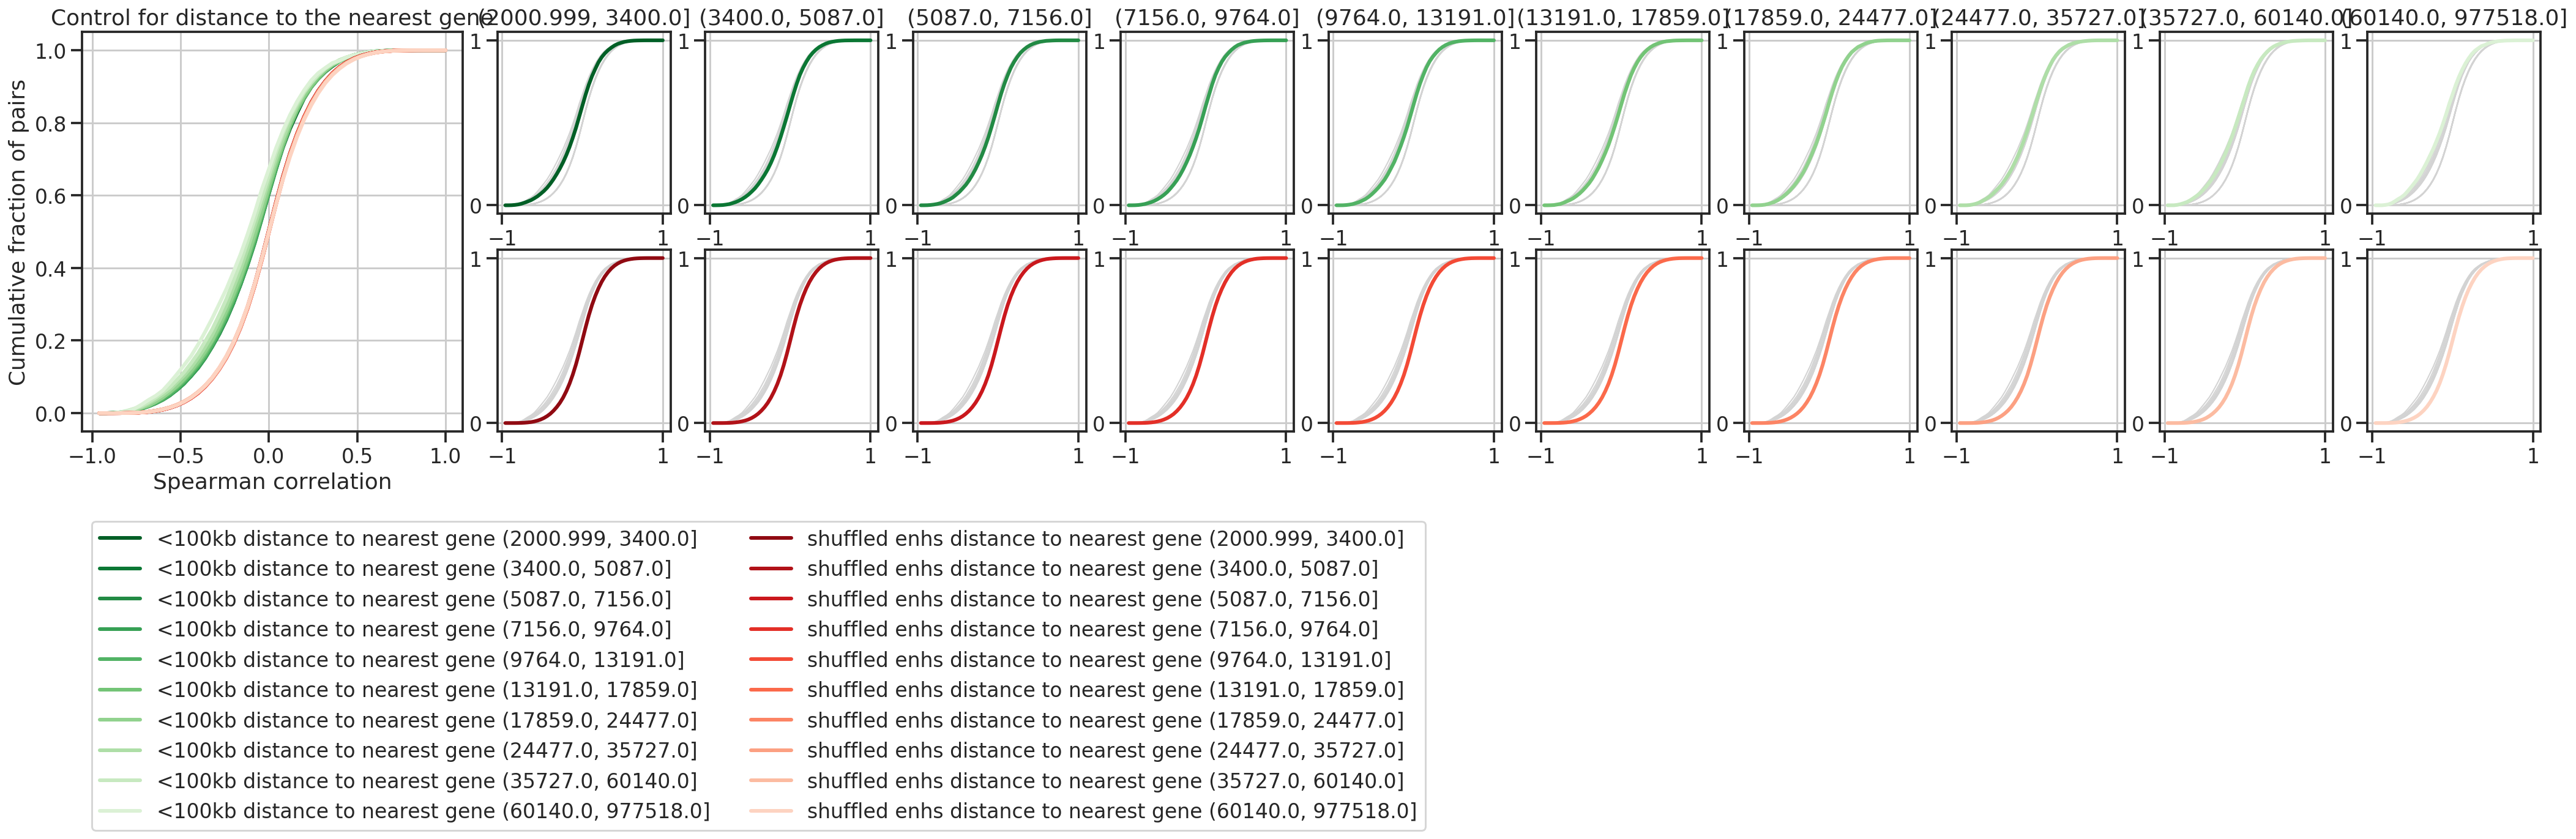

In [24]:
simple_plot_routine_cdf_v2(track_configs_dist, num_bins, 'Control for distance to the nearest gene', 'Spearman', ylim1=[], ylim2=[], 
                           output='/cndd2/fangming/projects/scf_enhancers/results_jan2021/cdf_control_nngene.pdf'
                          )

# Statistics

In [25]:
# 
track_configs = track_configs_dist

fdr_threshold=0.2
n = int(len(track_configs)/2)
for i in np.arange(n):
    label, track, color, _x, _y = track_configs[i]
    label2, track2, color2, _x, _y2 = track_configs[i+n]

    bins = np.hstack([[0], _x])
    cdf_data = _y
    cdf_shuff = _y2

    pval_shuff = enhancer_gene_utils.cumfrac_to_pval(cdf_shuff, 'left')
    pval_obs = enhancer_gene_utils.cumfrac_to_pval_obs_simple(cdf_data, 'left')
    fdr = (pval_shuff+1e-7)/(pval_obs+1e-7)
    try:
        r_threshold = enhancer_gene_utils.get_r_threshold_smart(bins, fdr, fdr_threshold, side='left')
    except:
        r_threshold = np.nan

    print(i, label, label2, r_threshold)

0 <100kb distance to nearest gene (2000.999, 3400.0] shuffled enhs distance to nearest gene (2000.999, 3400.0] -0.6261760382850324
1 <100kb distance to nearest gene (3400.0, 5087.0] shuffled enhs distance to nearest gene (3400.0, 5087.0] -0.6826414122805137
2 <100kb distance to nearest gene (5087.0, 7156.0] shuffled enhs distance to nearest gene (5087.0, 7156.0] -0.6767320408861749
3 <100kb distance to nearest gene (7156.0, 9764.0] shuffled enhs distance to nearest gene (7156.0, 9764.0] -0.6627603924179684
4 <100kb distance to nearest gene (9764.0, 13191.0] shuffled enhs distance to nearest gene (9764.0, 13191.0] -0.6575779034204061
5 <100kb distance to nearest gene (13191.0, 17859.0] shuffled enhs distance to nearest gene (13191.0, 17859.0] -0.6461320584945949
6 <100kb distance to nearest gene (17859.0, 24477.0] shuffled enhs distance to nearest gene (17859.0, 24477.0] -0.6565251092129705
7 <100kb distance to nearest gene (24477.0, 35727.0] shuffled enhs distance to nearest gene (2447

## Display two at a time 

In [26]:
def simple_plot_routine_cdf_v3(track_configs, num_bins, title, corr_type, 
                               fdr_threshold=0.2, ylim1=[], ylim2=[], output=''):
    """
    """
    # set up the figures 
    nx = int(num_bins/2+2.5)
    ny = 2
    fig = plt.figure(figsize=(nx*3, ny*3))
    gs = fig.add_gridspec(ny, nx)
    
    axs = np.hstack([
        [fig.add_subplot(gs[0:2, 0:2]),],
        [fig.add_subplot(gs[0, 2+i]) for i in np.arange(nx-2)],
        [fig.add_subplot(gs[1, 2+i]) for i in np.arange(nx-2)],
    ])
    
    # one plot
    ax = axs[0]
    for i, config in enumerate(track_configs):
        label, track, color, _x, _y = config
        ax.plot(_x, _y, label=label, color=color, linewidth=3, alpha=1)
        _handles, _labels = ax.get_legend_handles_labels()
    # labels
    ax.set_xlabel('{} correlation'.format(corr_type))
    ax.set_ylabel('Cumulative fraction of pairs')
    ax.legend(_handles, _labels, bbox_to_anchor=(0,-0.2), loc='upper left', ncol=2)
    ax.set_title(title)
    
    # many plots
    for j, ax in enumerate(axs[1:]):
        if j < num_bins:
            
            # all tracks first
            for i, config in enumerate(track_configs):
                label, track, color, _x, _y = config
                color='lightgray'
                ax.plot(_x, _y, label=label, color=color, linewidth=1, alpha=1)

            # shuff track
            label2, track2, color2, _x2, _y2 = track_configs[j+num_bins]
            ax.plot(_x2, _y2, label=label2, color=color2, linewidth=3, alpha=1)

            # this track
            label, track, color, _x, _y = track_configs[j]
            ax.plot(_x, _y, label=label, color=color, linewidth=3, alpha=1)
            ax.set_xticks([-1, 1])
            ax.set_yticks([0, 1])
        
            # r threshold
            bins = np.hstack([[0], _x])
            cdf_data = _y
            cdf_shuff = _y2
            pval_shuff = enhancer_gene_utils.cumfrac_to_pval(cdf_shuff, 'left')
            pval_obs = enhancer_gene_utils.cumfrac_to_pval_obs_simple(cdf_data, 'left')
            fdr = (pval_shuff+1e-7)/(pval_obs+1e-7)
            try:
                r_threshold = enhancer_gene_utils.get_r_threshold_smart(bins, fdr, fdr_threshold, side='left')
            except:
                r_threshold = np.nan
            
            # report
            short_label = "("+label.split('(')[1] + "\nr* = {:.2f}".format(r_threshold)
            ax.set_title(short_label, pad=10)
            
        else:
            ax.axis('off')
    
    fig.subplots_adjust(wspace=0.3, hspace=0.6)
    if output:
        snmcseq_utils.savefig(fig, output)
    plt.show()

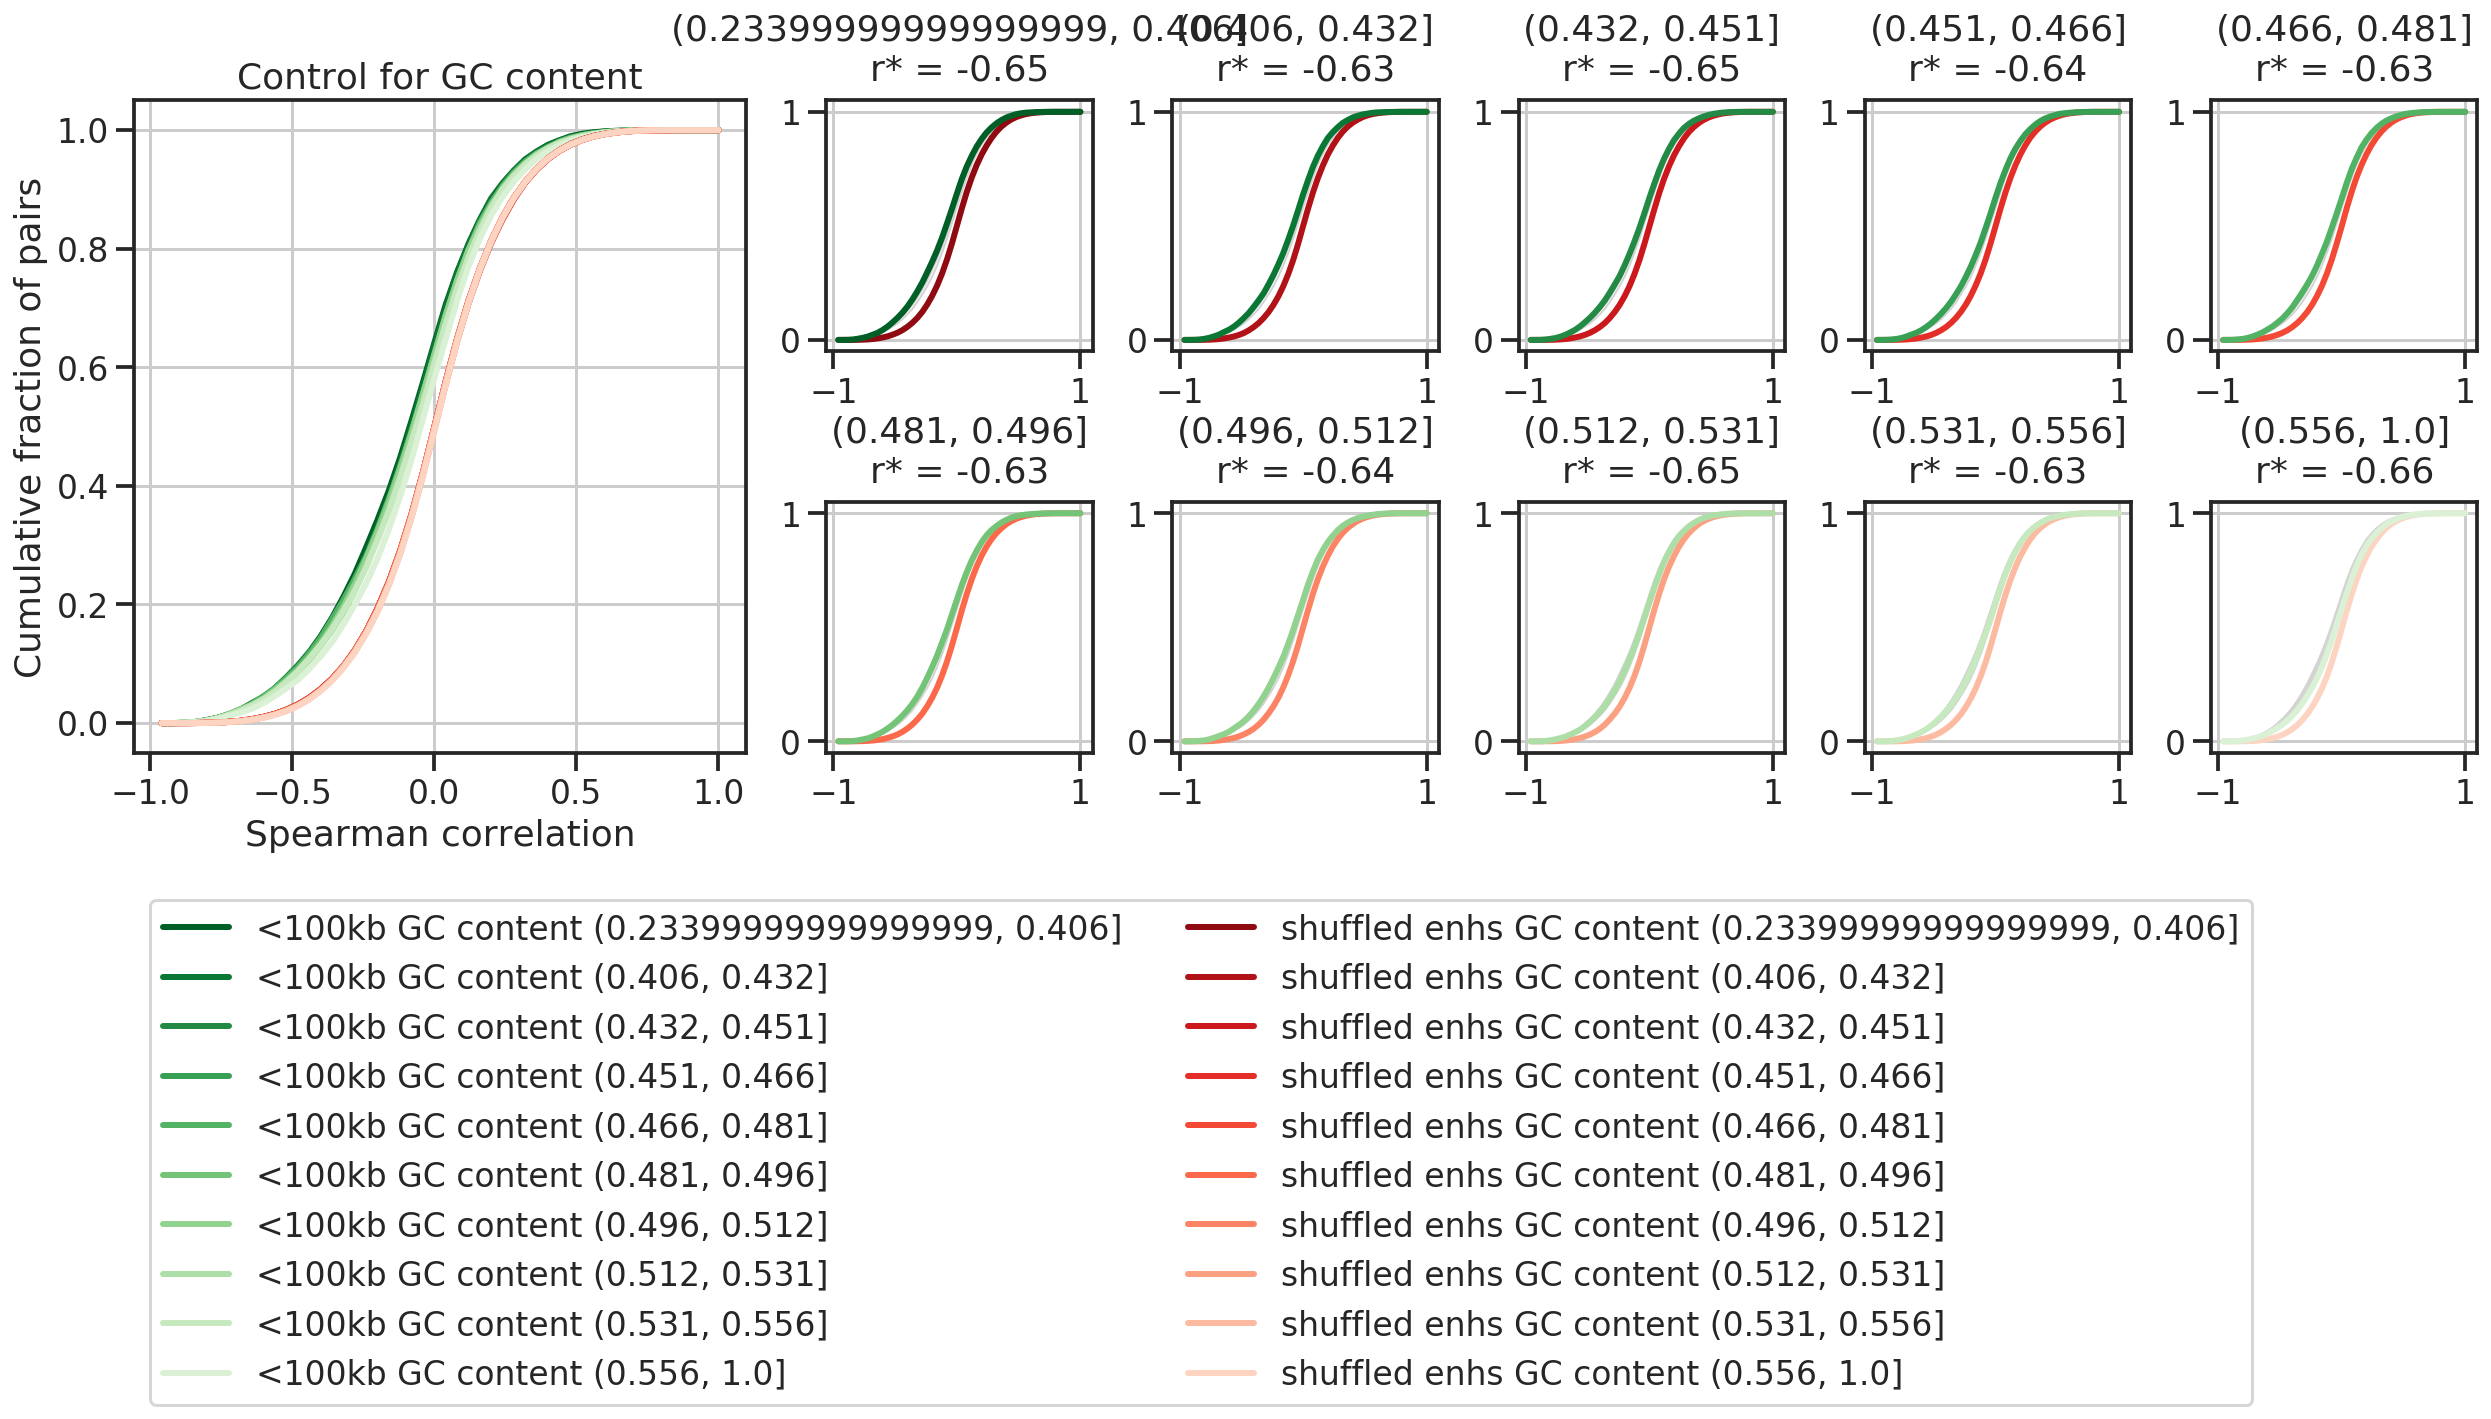

In [27]:
simple_plot_routine_cdf_v3(track_configs_gc, num_bins, 'Control for GC content', 'Spearman', ylim1=[], ylim2=[], 
                           output='/cndd2/fangming/projects/scf_enhancers/results_jan2021/cdf_control_gc_content_v3.pdf'
                          )

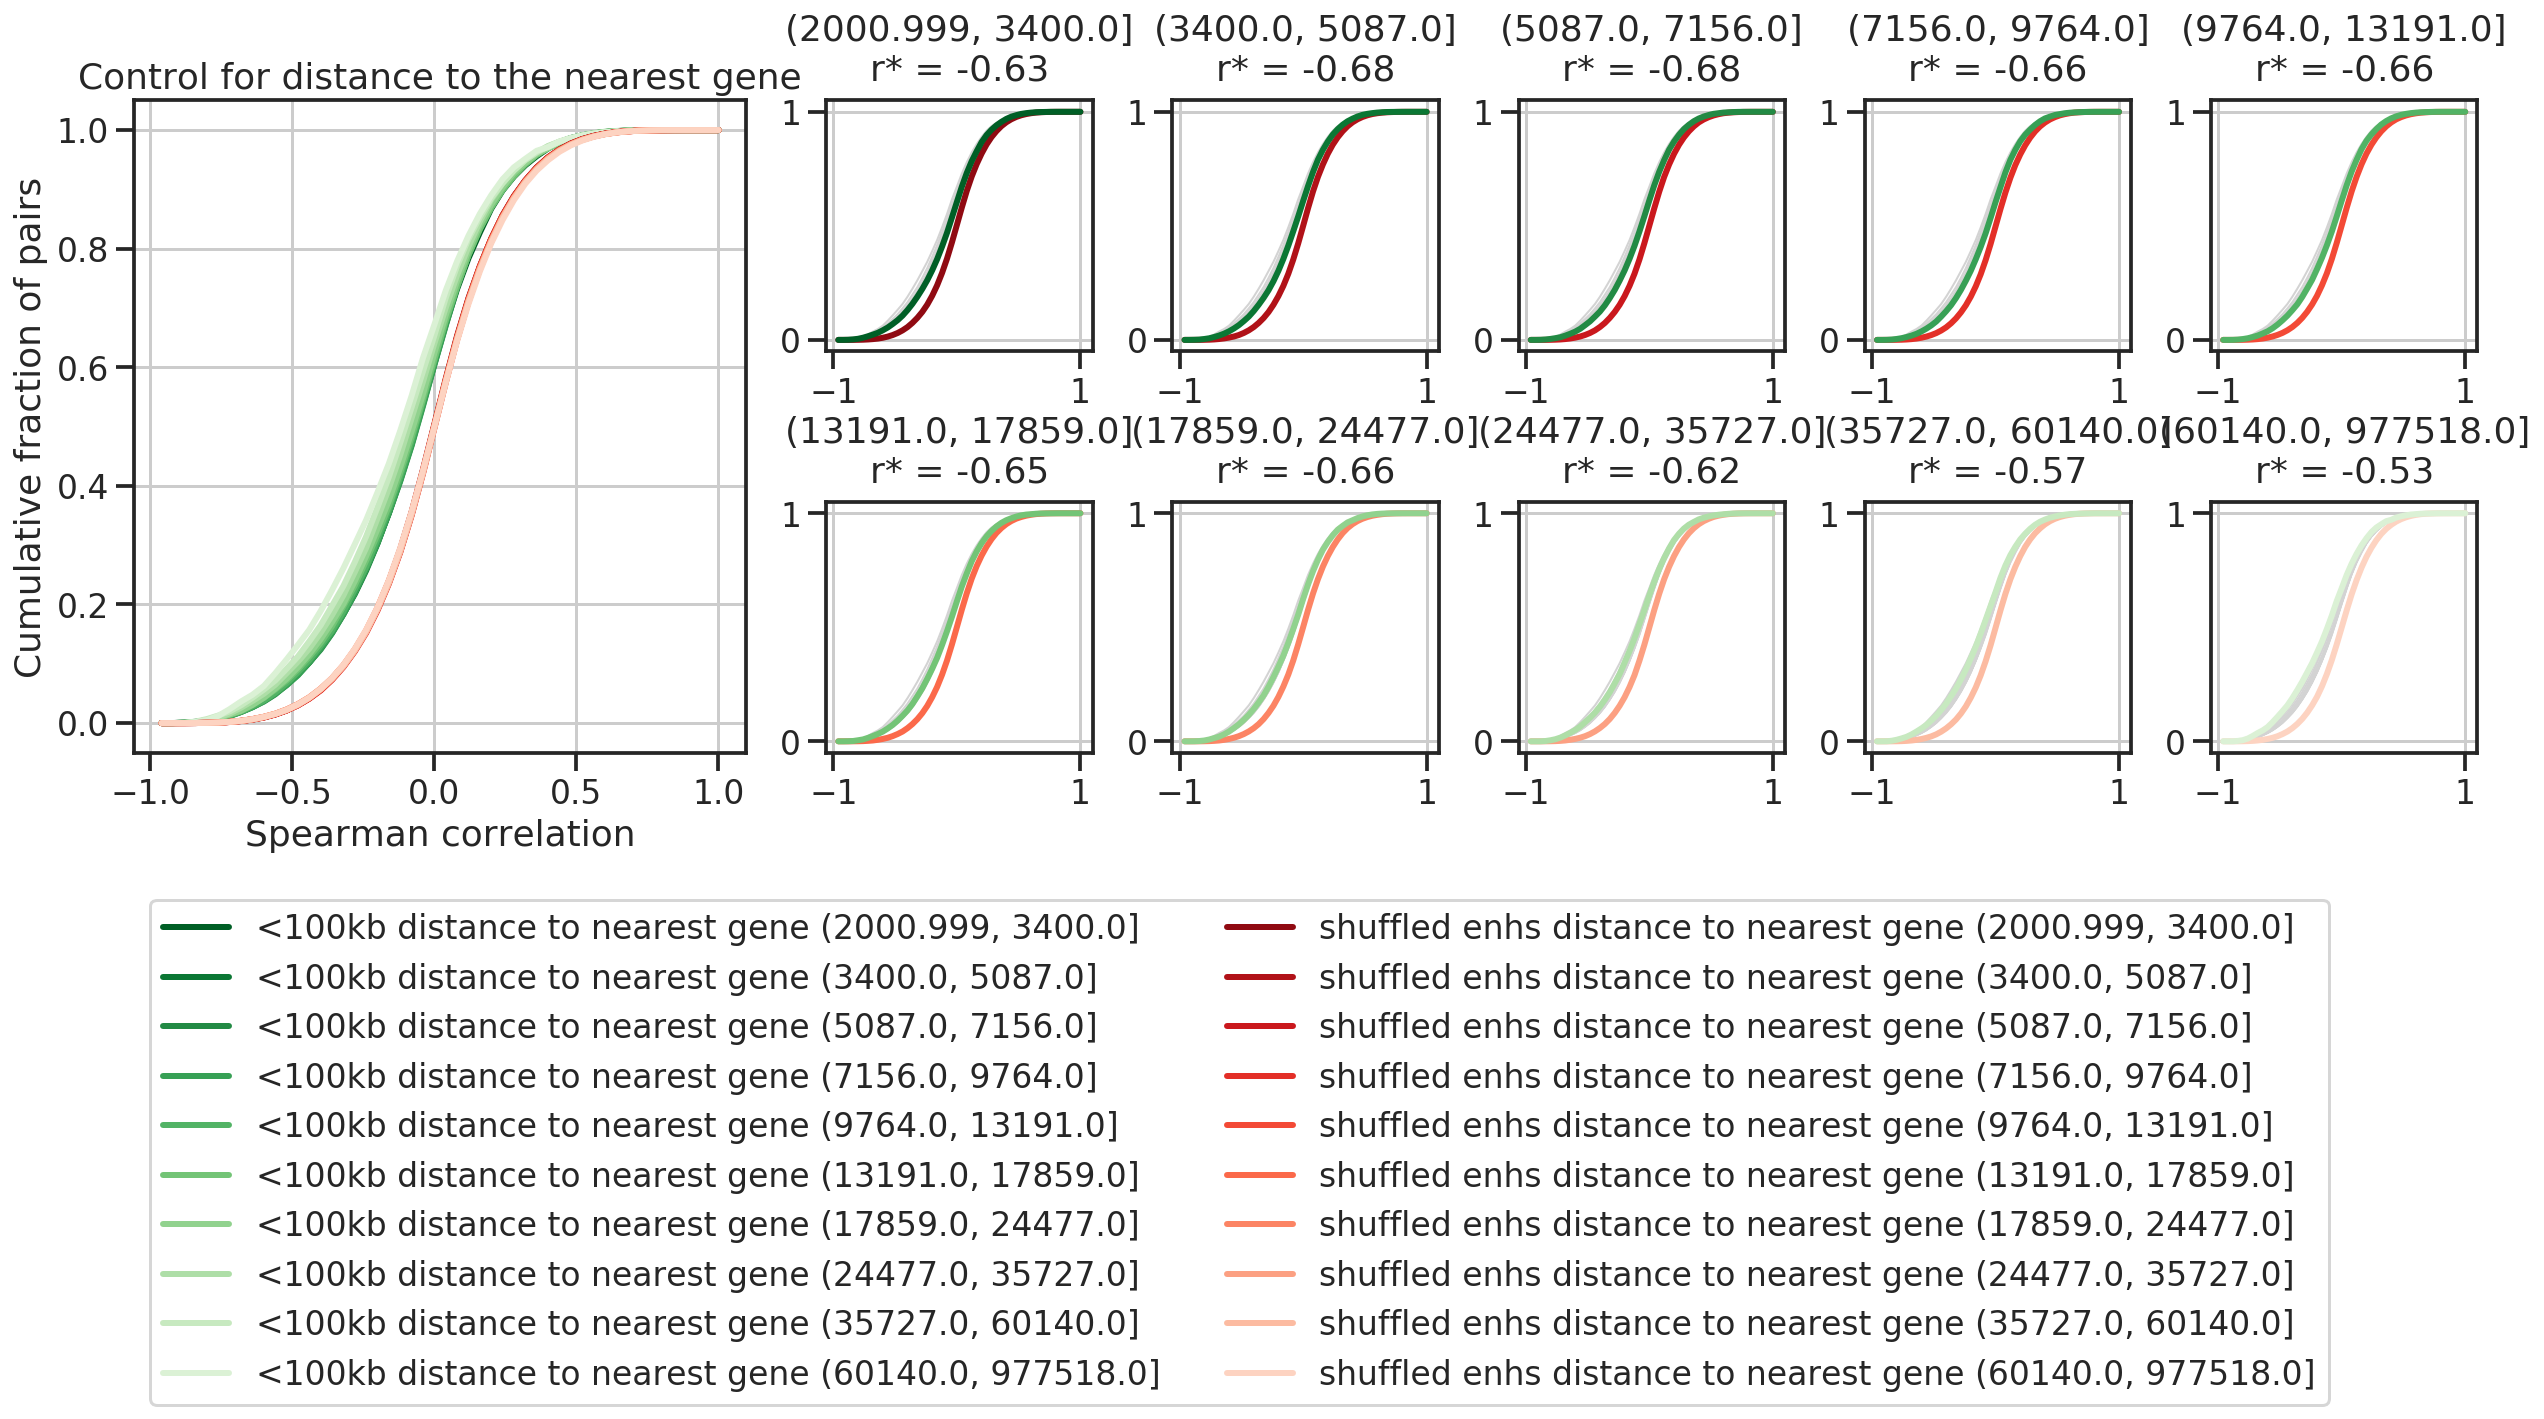

In [28]:
simple_plot_routine_cdf_v3(track_configs_dist, num_bins, 'Control for distance to the nearest gene', 'Spearman', ylim1=[], ylim2=[], 
                           output='/cndd2/fangming/projects/scf_enhancers/results_jan2021/cdf_control_nngene_v3.pdf'
                          )